In [1]:
# !pip install py_translator==2.1.9


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from py_translator import Translator
import matplotlib.pyplot as plt
import seaborn as sns
import Levenshtein as lev
from sklearn.cluster.bicluster import SpectralBiclustering
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
print(os.listdir("../input/competitive-data-science-predict-future-sales"))
# print(os.listdir('../input/glove-global-vectors-for-word-representation'))
# Any results you write to the current directory are saved as output.

['itemnamesinenglish', 'competitive-data-science-predict-future-sales']
['items.csv', 'sample_submission.csv', 'test.csv', 'sales_train.csv', 'item_categories.csv', 'shops.csv']


In [3]:
COMPETITION_DATA_DIRECTORY = '../input/competitive-data-science-predict-future-sales/'
SALES_FPATH = COMPETITION_DATA_DIRECTORY + 'sales_train.csv'
ITEMS_FPATH = COMPETITION_DATA_DIRECTORY + 'items.csv'
SHOPS_FPATH = COMPETITION_DATA_DIRECTORY + 'shops.csv'
TEST_SALES_FPATH = COMPETITION_DATA_DIRECTORY + 'test.csv'
ITEM_CATEGORIES_FPATH = COMPETITION_DATA_DIRECTORY + 'item_categories.csv'


In [4]:
sales = pd.read_csv(SALES_FPATH)
items = pd.read_csv(ITEMS_FPATH)
shops = pd.read_csv(SHOPS_FPATH)
categ = pd.read_csv(ITEM_CATEGORIES_FPATH)
test = pd.read_csv(TEST_SALES_FPATH)


In [5]:

def date_preprocessing(sales_df):
    if 'date_f' not in sales_df:
        sales_df['date_f'] = pd.to_datetime(sales_df.date, format='%d.%m.%Y')
        sales_df['month'] = sales_df.date_f.apply(lambda x: x.month)
        sales_df['year'] = sales_df.date_f.apply(lambda x: x.year)


def basic_preprocessing(sales_df):
    date_preprocessing(sales_df)
    sales_df.sort_values(['shop_id', 'item_id', 'date_f'], inplace=True)

    if 'shop_item_group' not in sales_df:
        shop_id_changed = sales_df.shop_id.diff() != 0
        item_id_changed = sales_df.item_id.diff() != 0
        ids_changed = shop_id_changed | item_id_changed
        sales_df['shop_item_group'] = ids_changed.cumsum()

basic_preprocessing(sales)

In [6]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [7]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [8]:
pd.concat([sales.head(),items.head()], axis=1, keys=['sales','items'])

sales                      ...          items                 
              date date_block_num       ...        item_id item_category_id
0              NaN            NaN       ...            0.0             40.0
1              NaN            NaN       ...            1.0             76.0
2              NaN            NaN       ...            2.0             40.0
3              NaN            NaN       ...            3.0             40.0
4              NaN            NaN       ...            4.0             40.0
173345  20.02.2013            1.0       ...            NaN              NaN
173346  18.02.2013            1.0       ...            NaN              NaN
173347  17.02.2013            1.0       ...            NaN              NaN
173348  16.02.2013            1.0       ...            NaN              NaN
173349  15.02.2013            1.0       ...            NaN              NaN

[10 rows x 13 columns]

In [9]:
pd.concat([shops.head(), categ.head()], axis=1, keys=['shops','categories'])

shops       ...              categories
                        shop_name       ...        item_category_id
0   !Якутск Орджоникидзе, 56 фран       ...                       0
1   !Якутск ТЦ "Центральный" фран       ...                       1
2                Адыгея ТЦ "Мега"       ...                       2
3  Балашиха ТРК "Октябрь-Киномир"       ...                       3
4        Волжский ТЦ "Волга Молл"       ...                       4

[5 rows x 4 columns]

In [10]:
print('sales shape', sales.shape)
print('items shape', items.shape)
print('categories shape', categ.shape)
print('shops shape', shops.shape)
print('')
print('')
print('Num days', len(sales.date.unique()))

sales shape (2935849, 10)
items shape (22170, 3)
categories shape (84, 2)
shops shape (60, 2)


Num days 1034


In [11]:
counts = sales.groupby(['item_id'])['item_price'].count()
print('Item coming in the training only once', 100* round((counts == 1).sum() / counts.shape[0],2))
print('Item coming in the training (0,10]', 100* round(((counts <= 10) &(counts >0)).sum() / counts.shape[0],2))
print('Item coming in the training (10,20]', 100* round(((counts <= 20) &(counts >10)).sum() / counts.shape[0],2))
print('Item coming in the training (20,30]', 100* round(((counts <= 30) &(counts >20)).sum() / counts.shape[0],2))
print('Item coming in the training (30,100]', 100* round(((counts <= 100) &(counts >30)).sum() / counts.shape[0],2))
print('Item coming in the training (100,~)', 100* round((counts >100).sum() / counts.shape[0],2))

Item coming in the training only once 11.0
Item coming in the training (0,10] 31.0
Item coming in the training (10,20] 11.0
Item coming in the training (20,30] 7.000000000000001
Item coming in the training (30,100] 23.0
Item coming in the training (100,~) 28.000000000000004


In [12]:
price_max = sales.groupby(['item_id'])['item_price'].max()
price_std = sales.groupby(['item_id'])['item_price'].std()/price_max
price_std = price_std.loc[counts[counts >=10].index]

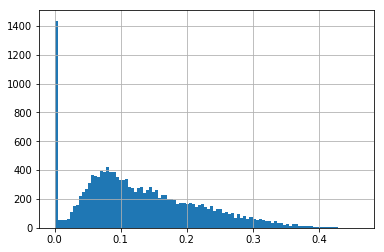

In [13]:
price_std.hist(bins=100)

In [14]:
print('Non-price deviating ==>', round((price_std == 0).sum()/price_std.shape[0] * 100, 2))
print('0< Deviation < 0.1 ==>', round(((price_std > 0) & (price_std < 0.1)).sum()/price_std.shape[0] * 100, 2))
print('0.1< Deviation < 0.2 ==>', round(((price_std > 0.1) & (price_std < 0.2)).sum()/price_std.shape[0] * 100, 2))
print('0.2< Deviation < 0.3 ==>', round(((price_std > 0.2) & (price_std < 0.3)).sum()/price_std.shape[0] * 100, 2))

Non-price deviating ==> 8.59
0< Deviation < 0.1 ==> 35.75
0.1< Deviation < 0.2 ==> 34.48
0.2< Deviation < 0.3 ==> 16.85


**There is some information in changing price as we see that price is changing and is not constant for all times.**

## Checking which shop_id, item_id is extra in train/test

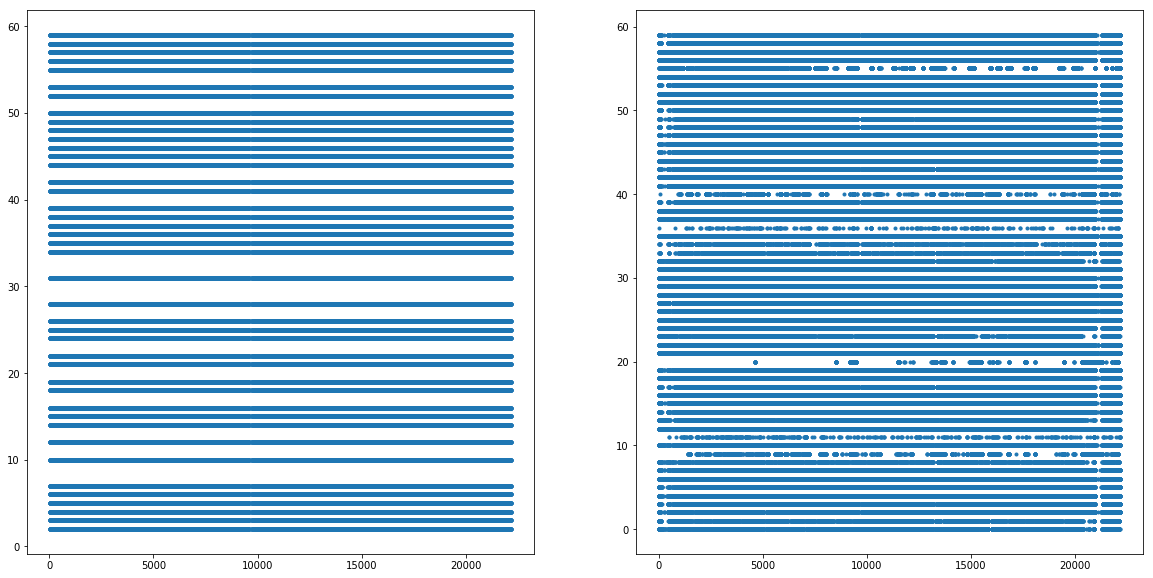

In [15]:
_, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(test['item_id'], test['shop_id'], '.')
ax[1].plot(sales['item_id'],sales['shop_id'], '.')

In [16]:
print('Extra items in test set which are not present in train set', len(set(test['item_id'].unique()) - set(sales['item_id'].unique())))

Extra items in test set which are not present in train set 363


**This means we need some sort of cluster**

In [17]:
print('No new shops come in test', set(test['shop_id'].unique()) - set(sales['shop_id'].unique()))

No new shops come in test set()


In [18]:
print('Train has some extra shops', set(sales['shop_id'].unique()) - set(test['shop_id'].unique()))

Train has some extra shops {0, 1, 32, 33, 8, 9, 40, 11, 43, 13, 17, 51, 20, 54, 23, 27, 29, 30}


In [19]:
extra_item_ids = list(set(test['item_id'].unique()) - set(sales['item_id'].unique()))
extra_item_ids.sort()

In [20]:
category_to_item_df = items.groupby('item_category_id')['item_id'].apply(list)
item_to_category = items.set_index('item_id')['item_category_id']

### Text features

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
item_name_vectorizer = CountVectorizer()
item_name_vectorizer.fit(items.item_name.values)
print('Number of features which will get added should we consider item_name', len(item_name_vectorizer.get_feature_names()))



Number of features which will get added should we consider item_name 18222


In [22]:
item_name_vectorizer = CountVectorizer()
X_orig = item_name_vectorizer.fit_transform(items.item_name.values)

In [23]:
item_name_vectorizer = CountVectorizer(max_features=10000)
X = item_name_vectorizer.fit_transform(items.item_name.values)

In [24]:
print('Percentage of word occurances covered when using 10K feature size:',(round(X.sum()/X_orig.sum(),2) * 100))

Percentage of word occurances covered when using 10K feature size: 94.0


**We therefore need to use WordToVec features to process item name as we cannot afford to have 10K features. **

In [25]:
shop_name_vectorizer = CountVectorizer()
shop_name_vectorizer.fit(shops.shop_name.values)
print('Number of features which will get added should we consider shop_name', len(shop_name_vectorizer.get_feature_names()))


Number of features which will get added should we consider shop_name 113


In [26]:
catg_name_vectorizer = CountVectorizer()
catg_name_vectorizer.fit(categ.item_category_name.values)
print('Number of features which will get added should we consider category_name', len(catg_name_vectorizer.get_feature_names()))


Number of features which will get added should we consider category_name 98


#### Lets look at  dependency of categories on sales.

In [27]:
sales['date_f'] = pd.to_datetime(sales.date, format='%d.%m.%Y')
sales['month'] = sales.date_f.apply(lambda x: x.month)
sales['year'] = sales.date_f.apply(lambda x: x.year)

In [28]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_f,month,year,shop_item_group
173349,15.02.2013,1,0,30,265.0,2.0,2013-02-15,2,2013,1
173348,16.02.2013,1,0,30,265.0,9.0,2013-02-16,2,2013,1
173347,17.02.2013,1,0,30,265.0,4.0,2013-02-17,2,2013,1
173346,18.02.2013,1,0,30,265.0,4.0,2013-02-18,2,2013,1
173345,20.02.2013,1,0,30,265.0,2.0,2013-02-20,2,2013,1


In [29]:
print('-ve priced examples', (sales['item_price'] < 0).sum())

-ve priced examples 1


In [30]:
print('> 10K priced examples', '{}K'.format((sales['item_price'] > 10_000).sum()/1000))
print('< 10K priced examples', '{}K'.format((sales['item_price'] < 10_000).sum()/1000))

> 10K priced examples 19.745K
< 10K priced examples 2916.104K


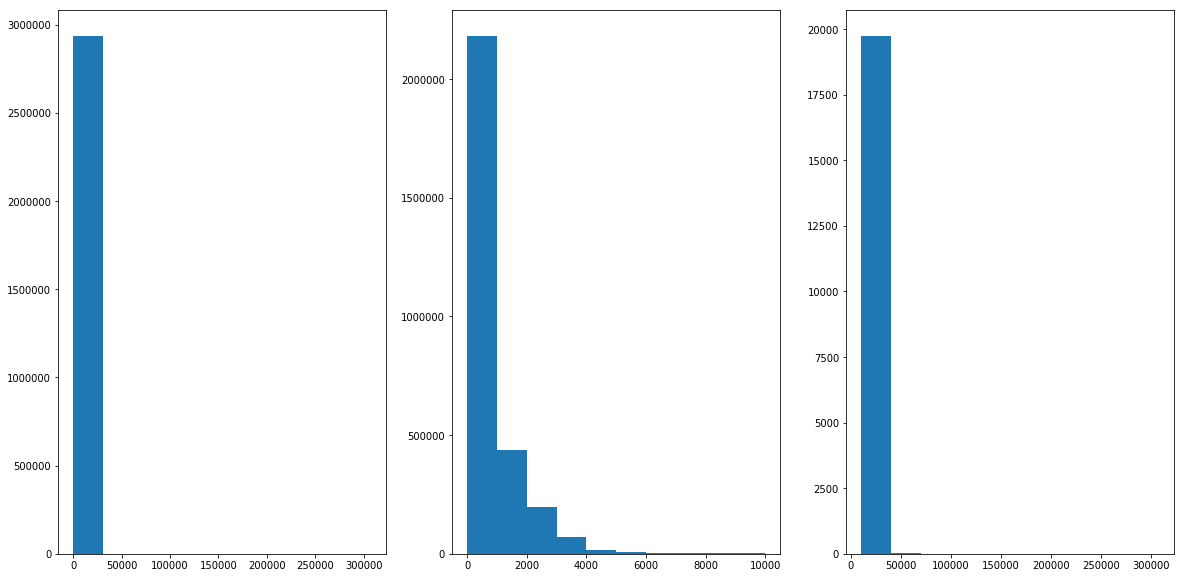

In [31]:
_, ax = plt.subplots(1,3, figsize=(20,10))
_ = ax[0].hist(sales['item_price'])
_ = ax[1].hist(sales[sales['item_price'] < 10_000]['item_price'])
_ = ax[2].hist(sales[sales['item_price'] > 10_000]['item_price'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


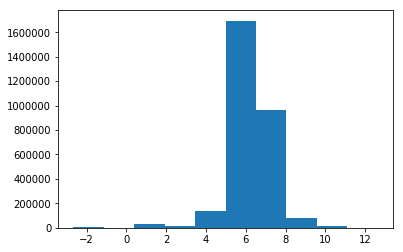

In [32]:
_ = plt.hist(np.log(sales['item_price']))

In [33]:
print('Number of invalid price entries', np.log(sales['item_price']).isna().sum())

Number of invalid price entries 1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


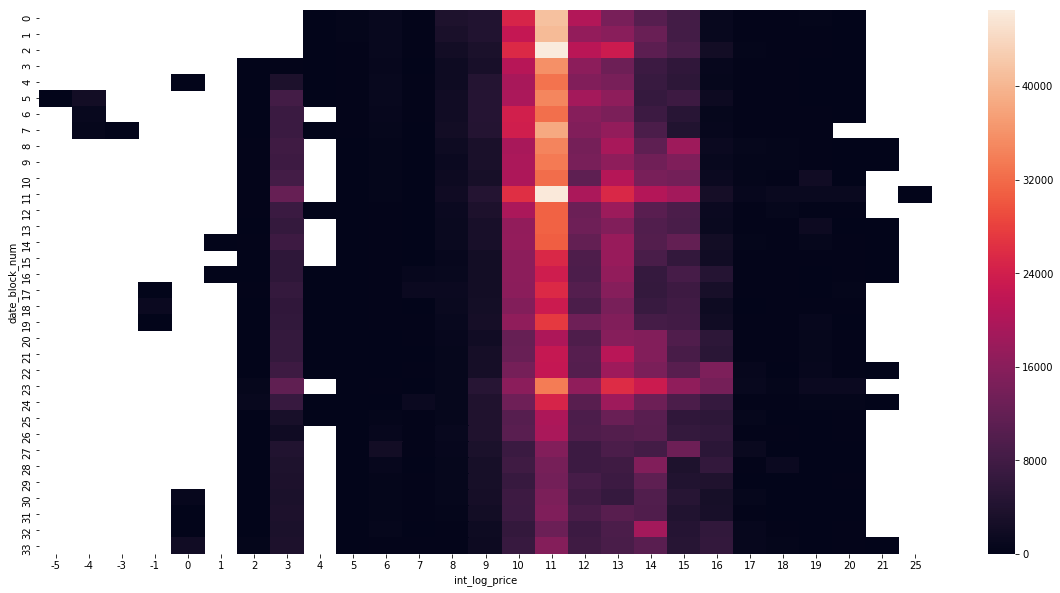

In [34]:
_,ax = plt.subplots(figsize=(20,10))
sales['log_price'] = np.log(sales['item_price'])
sales['int_log_price'] = (2 * sales['log_price'].fillna(0)).astype(int)
_ = sns.heatmap(sales.groupby(['date_block_num','int_log_price'])['item_cnt_day'].sum().unstack(), ax=ax)

**We can see some patterns here in the log price. For example, there are some months in which the sales are good. Different price ranges 
have different amount of sales in general**

In [35]:
merged_df = pd.merge(sales, items, how='left', on='item_id')

In [36]:
merged_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_f,month,year,shop_item_group,log_price,int_log_price,item_name,item_category_id
0,15.02.2013,1,0,30,265.0,2.0,2013-02-15,2,2013,1,5.57973,11,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
1,16.02.2013,1,0,30,265.0,9.0,2013-02-16,2,2013,1,5.57973,11,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
2,17.02.2013,1,0,30,265.0,4.0,2013-02-17,2,2013,1,5.57973,11,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
3,18.02.2013,1,0,30,265.0,4.0,2013-02-18,2,2013,1,5.57973,11,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
4,20.02.2013,1,0,30,265.0,2.0,2013-02-20,2,2013,1,5.57973,11,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40


In [37]:
df = merged_df.groupby(['shop_id', 'item_category_id', 'date_block_num'])['item_cnt_day'].sum().reset_index()
df = df.groupby(['shop_id', 'item_category_id'])['item_cnt_day'].mean()
df[df > 20] = 20

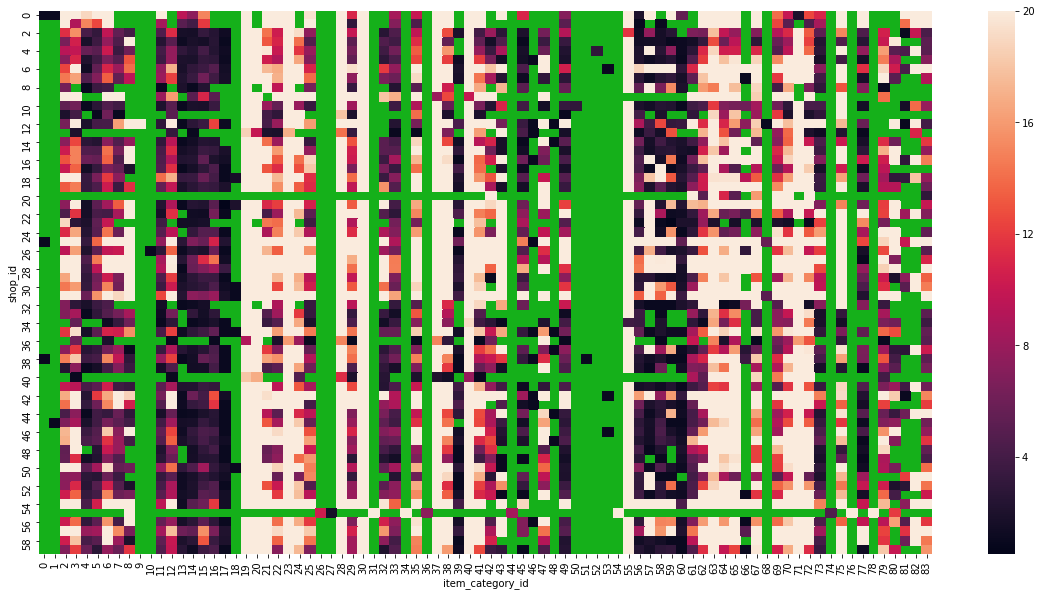

In [38]:
_, ax = plt.subplots(figsize=(20,10))
data_df = df.unstack()
mask = data_df.isna().values
hm = sns.heatmap(data_df, ax=ax, mask=mask)
hm.set_facecolor('xkcd:green')


In [39]:
uns_df = df.unstack()

In [40]:
uns_df.fillna(uns_df.mean())

item_category_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
shop_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,20.000000,20.000000,19.000000,20.000000,20.000000,8.688095,12.350379,20.0,1.0,20.000000,10.861711,9.500000,7.500000,15.000000,4.882620,1.338519,1.277778,20.000000,19.749400,20.000000,20.000000,20.00000,17.127967,19.500000,10.363636,1.6,20.000000,11.000000,20.0,20.0,8.547349,8.500000,20.0,10.000000,7.333333,20.000000,20.000000,2.321672,...,8.4,11.000000,1.0,13.110370,1.0,7.000000,3.0,1.0,3.0,1.0,20.0,20.000000,2.000000,20.000000,6.131102,20.000000,5.500000,8.244607,20.000000,20.000000,20.000000,20.000000,10.945652,20.000000,3.909091,14.000000,10.000000,2.000000,12.500000,11.000000,4.538462,20.000000,20.0,20.000000,20.0,12.096253,11.398198,20.000000,20.000000,20.000000
1,1.0,1.0,20.000000,9.000000,15.000000,12.500000,20.000000,8.688095,12.350379,20.0,1.0,8.500000,10.861711,5.000000,4.000000,12.000000,4.882620,1.338519,1.277778,20.000000,19.749400,20.000000,20.000000,20.00000,17.127967,20.000000,10.363636,1.6,20.000000,3.000000,20.0,20.0,8.547349,7.000000,20.0,4.500000,7.333333,20.000000,20.000000,2.321672,...,8.4,5.204856,1.0,13.110370,1.0,5.000000,3.0,1.0,3.0,1.0,20.0,20.000000,1.000000,10.122998,1.000000,8.295613,1.922008,8.244607,20.000000,20.000000,20.000000,20.000000,10.945652,20.000000,3.909091,12.500000,5.000000,19.592593,4.500000,8.500000,4.538462,20.000000,20.0,20.000000,20.0,12.096253,11.398198,14.000000,20.000000,20.000000
2,1.0,1.0,11.451613,15.500000,4.200000,3.125000,9.676471,5.428571,4.000000,20.0,1.0,4.592593,11.272727,1.666667,1.625000,3.178571,2.416667,1.333333,1.277778,20.000000,20.000000,14.212121,10.382353,20.00000,19.214286,7.555556,10.363636,1.6,20.000000,9.882353,20.0,20.0,2.500000,4.515152,20.0,9.647059,7.333333,20.000000,12.735294,2.000000,...,8.4,2.000000,1.0,6.250000,1.0,9.193548,3.0,1.0,3.0,1.0,20.0,11.709677,1.400000,7.666667,1.615385,2.500000,1.922008,6.722222,6.388889,17.735294,9.735294,7.794118,10.945652,6.909091,3.909091,9.115385,11.129032,20.000000,13.294118,5.151515,4.538462,15.058824,20.0,4.500000,20.0,10.571429,11.398198,1.000000,10.000000,4.250000
3,1.0,1.0,6.451613,10.588235,1.866667,3.689655,7.696970,4.500000,20.000000,20.0,1.0,2.428571,4.954545,1.200000,1.869565,1.578947,2.545455,1.000000,1.277778,20.000000,20.000000,13.121212,10.911765,20.00000,14.071429,4.692308,10.363636,1.6,20.000000,5.187500,20.0,20.0,4.571429,3.812500,20.0,11.382353,7.333333,20.000000,5.515152,2.321672,...,8.4,1.000000,1.0,3.500000,1.0,3.370370,3.0,1.0,3.0,1.0,20.0,20.000000,1.428571,1.500000,1.600000,1.000000,1.125000,1.500000,3.238095,12.705882,5.843750,9.529412,10.945652,2.851852,3.909091,5.687500,8.062500,20.000000,12.235294,2.423077,4.538462,4.588235,20.0,2.600000,20.0,10.080000,19.800000,6.139665,18.822981,5.090909
4,1.0,1.0,9.363636,9.794118,5.611111,5.032258,10.212121,3.538462,6.000000,20.0,1.0,4.000000,7.590909,3.000000,2.320000,4.000000,2.363636,1.333333,1.277778,20.000000,20.000000,19.705882,10.090909,20.00000,11.714286,7.852941,10.363636,1.6,20.000000,6.322581,20.0,20.0,3.750000,6.064516,20.0,13.352941,7.333333,20.000000,15.823529,2.321672,...,8.4,1.750000,1.0,5.750000,1.0,2.192308,3.0,1.0,3.0,1.0,20.0,20.000000,2.052632,20.000000,2.545455,7.500000,1.142857,2.733333,11.153846,18.882353,10.406250,10.562500,10.945652,11.029412,3.909091,4.812500,9.562500,20.000000,13.852941,2.838710,4.538462,20.000000,20.0,7.571429,20.0,16.161290,5.000000,4.428571,20.000000,5.000000
5,1.0,1.0,7.250000,10.967742,2.111111,3.800000,6.593750,4.857143,13.000000,20.0,1.0,3.571429,7.714286,2.000000,1.941176,3.153846,2.909091,1.142857,1.277778,20.000000,20.000000,10.333333,8.969697,20.00000,16.500000,6.968750,10.363636,1.6,20.000000,5.375000,20.0,20.0,2.785714,4.344828,20.0,12.393939,7.3

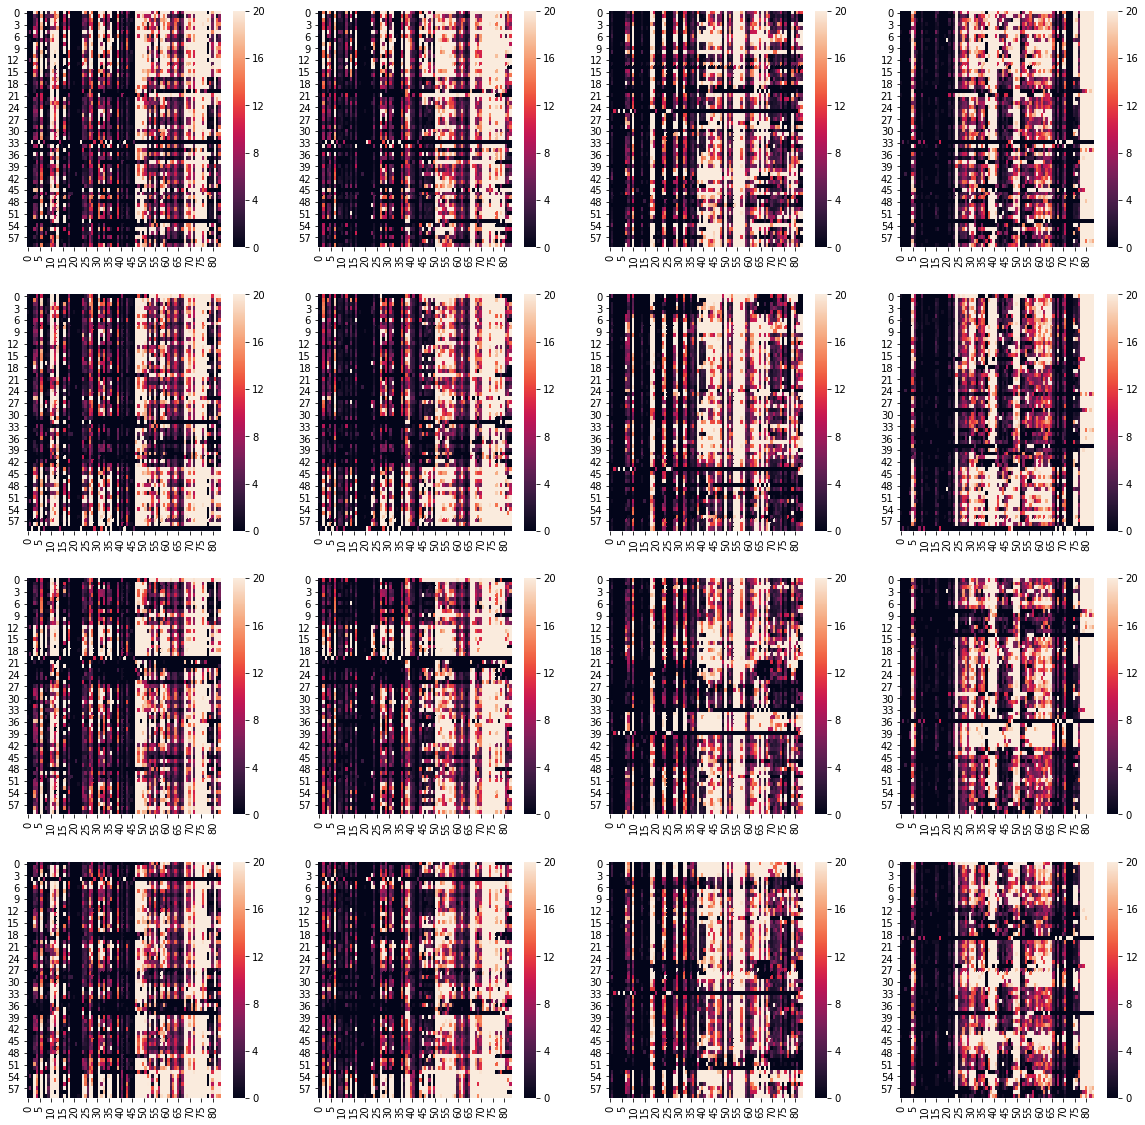

In [41]:
data =df.unstack()
data = data.fillna(0).values
_, ax = plt.subplots(4,4,figsize=(20,20))
for i, row_cnt in enumerate([2,4, 8,16]):
    for j, col_cnt in enumerate([2,4,8,16]):
        n_clusters=(row_cnt,col_cnt)
        model = SpectralBiclustering(n_clusters=n_clusters,method='log',
                                     random_state=0)
        model.fit(data)
        fit_data = data[np.argsort(model.row_labels_)]
        fit_data = fit_data[:, np.argsort(model.column_labels_)]

        sns.heatmap(fit_data, ax=ax[i,j])

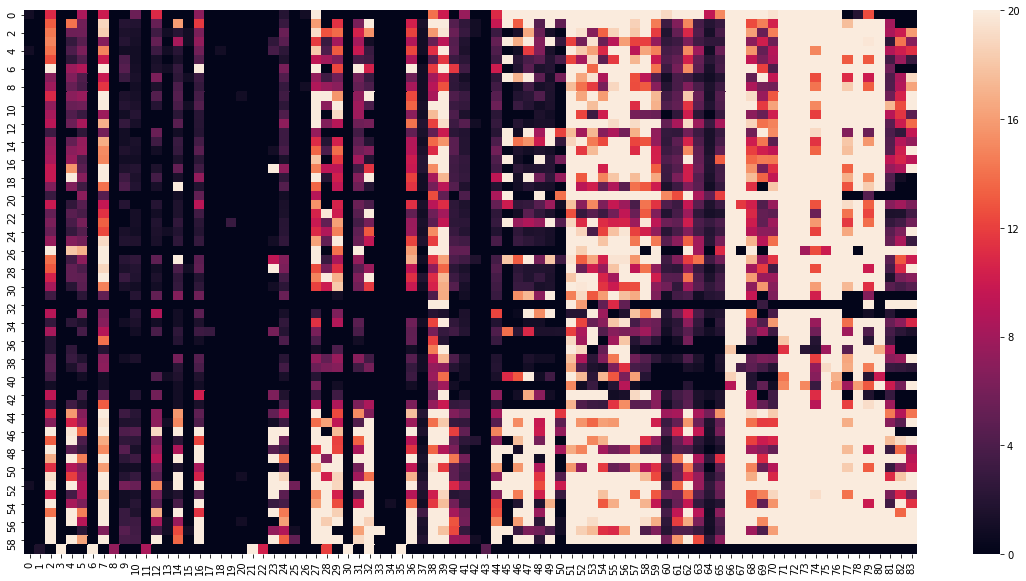

In [42]:
_, ax = plt.subplots(figsize=(20,10))
n_clusters=(4,4)
model = SpectralBiclustering(n_clusters=n_clusters,method='log',
                             random_state=0)
model.fit(data)
fit_data = data[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

sns.heatmap(fit_data, ax=ax)

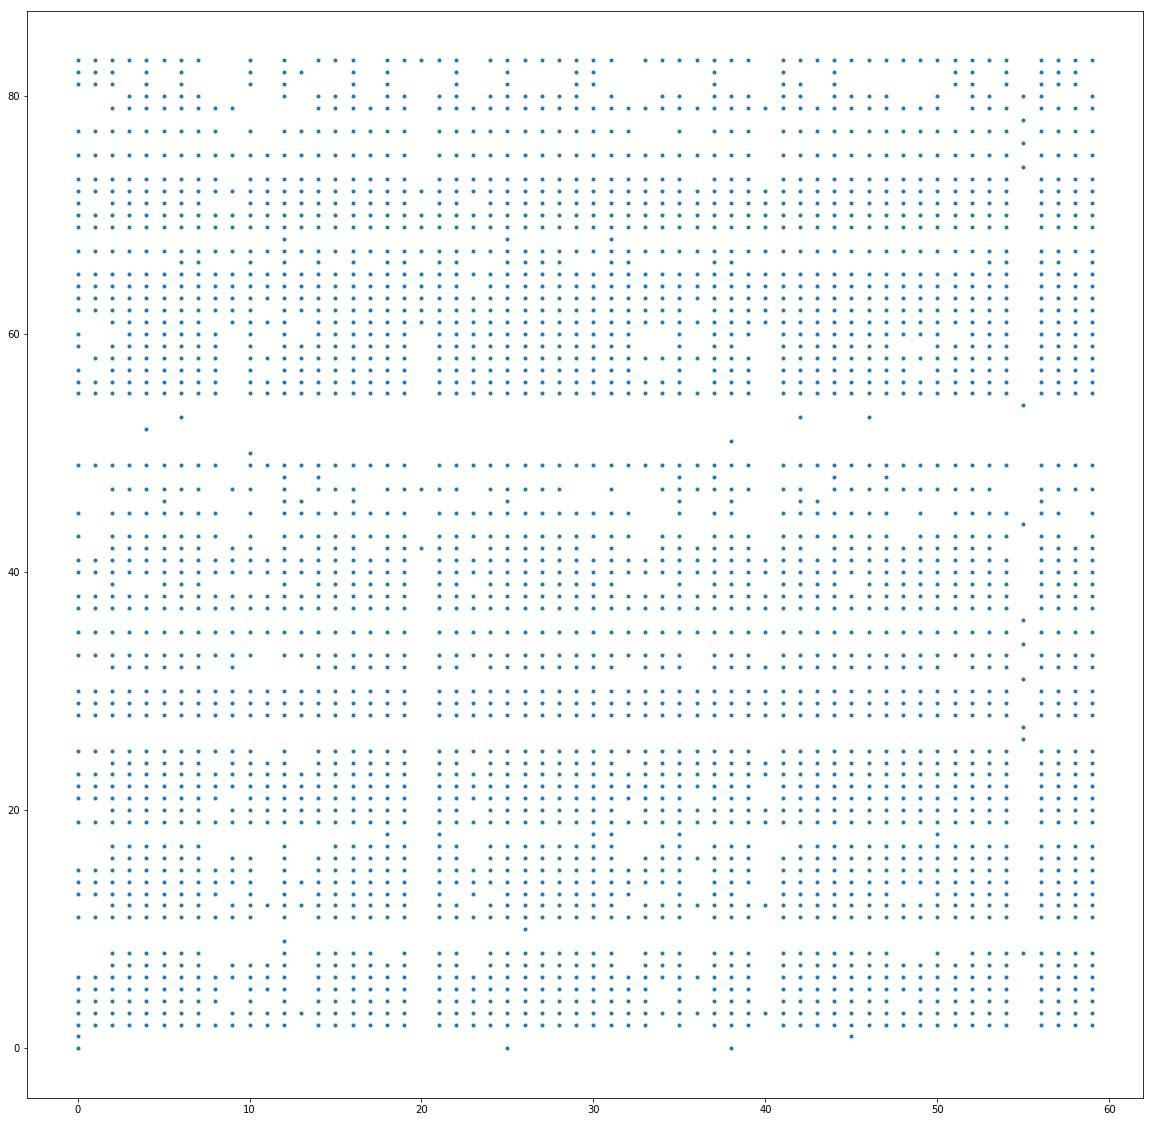

In [43]:
_, ax = plt.subplots(figsize=(20,20))
df = merged_df.groupby(['shop_id', 'item_category_id'])['item_cnt_day'].mean().reset_index()
ax.plot(df['shop_id'], df['item_category_id'], '.')

**We see that not every combination of shop_id and category_id is covered. We will now have to resort to shop agnostic features for items and item agnostic features for shops**

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until


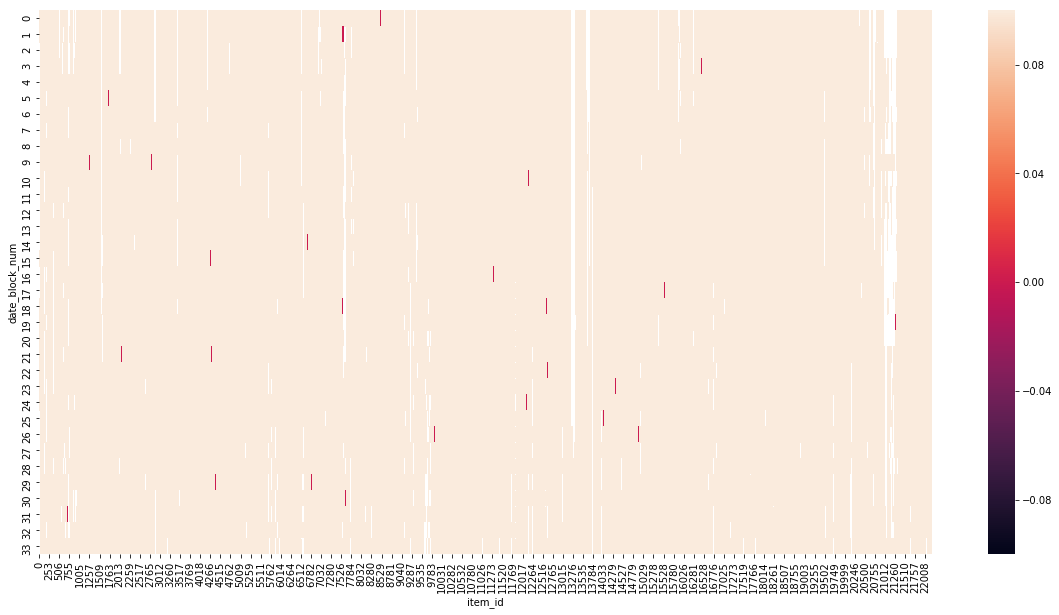

In [44]:
_,ax = plt.subplots(figsize=(20,10))
item_month_sales =merged_df.groupby(['date_block_num','item_id'])['item_cnt_day'].sum()
_ = sns.heatmap(np.log1p(item_month_sales).unstack(), ax=ax)

In [45]:
item_month_sales.value_counts().head(10)

1.0     56362
2.0     30438
3.0     20780
4.0     15795
5.0     12244
6.0      9933
7.0      8392
8.0      7116
9.0      6167
10.0     5241
Name: item_cnt_day, dtype: int64

**We see that there are no entries for items not sold****.**

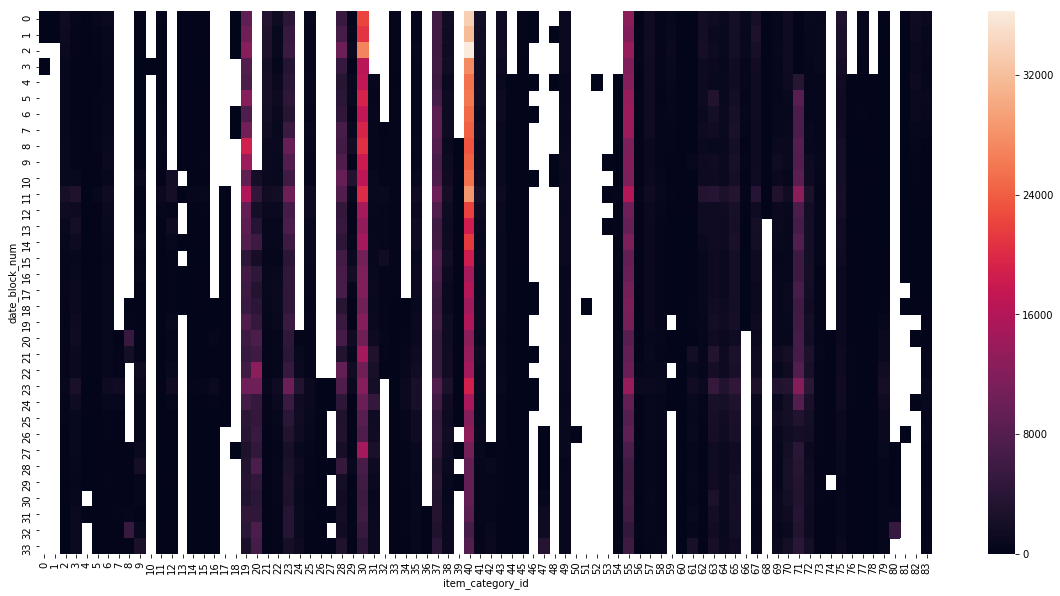

In [46]:
_,ax = plt.subplots(figsize=(20,10))
_ = sns.heatmap(merged_df.groupby(['date_block_num','item_category_id'])['item_cnt_day'].sum().unstack(), ax=ax)